<img src='https://securityintelligence.com/wp-content/uploads/2017/08/autonomousself-drivingca_469385.jpg'>

# German traffic sign classification - https://www.kaggle.com/competitions/acc-german-traffic-sign-classification/overview
## Author: Ori Nissim
### Data Description:
German traffic sign dataset contains about 39000 training images and 12000 testing images of 43 classes with class id ranging from 0 to 43. Participant joining this competition will try to predict a class id for each testing image 


# Introduction 
#### In this notebook i'm going to document my work with great detail and demonstrate the process of participating in a Kaggle's multi-class classifitcation competition.
#### The desired result is of course to submit out model's result on the test set and hopefully it will preform well!

## The process
1. Get the data and analize it
2. Making a dataloader and augmentations
3. Building a model & training 
4. Visualizing predictions, results and metrics
5. Prediciting test set and submission

## Essential libraries imports



In [1]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import copy
import os
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time

import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models

!pip install opendatasets
import opendatasets as od

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Getting the dataset

In [2]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip


--2022-07-30 19:34:26--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.4MB/s    in 12s     

2022-07-30 19:34:39 (21.5 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Number of classes ( types of traffic signs )

In [3]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

## Helper functions
* load image - load image while converting to RGB with resize option
* show image - show the image, given it's path
* plot_signs - plot multiple signs images in a grid

In [4]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def plot_signs(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)  # RGB indices
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

### Let's see 43 random images from the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


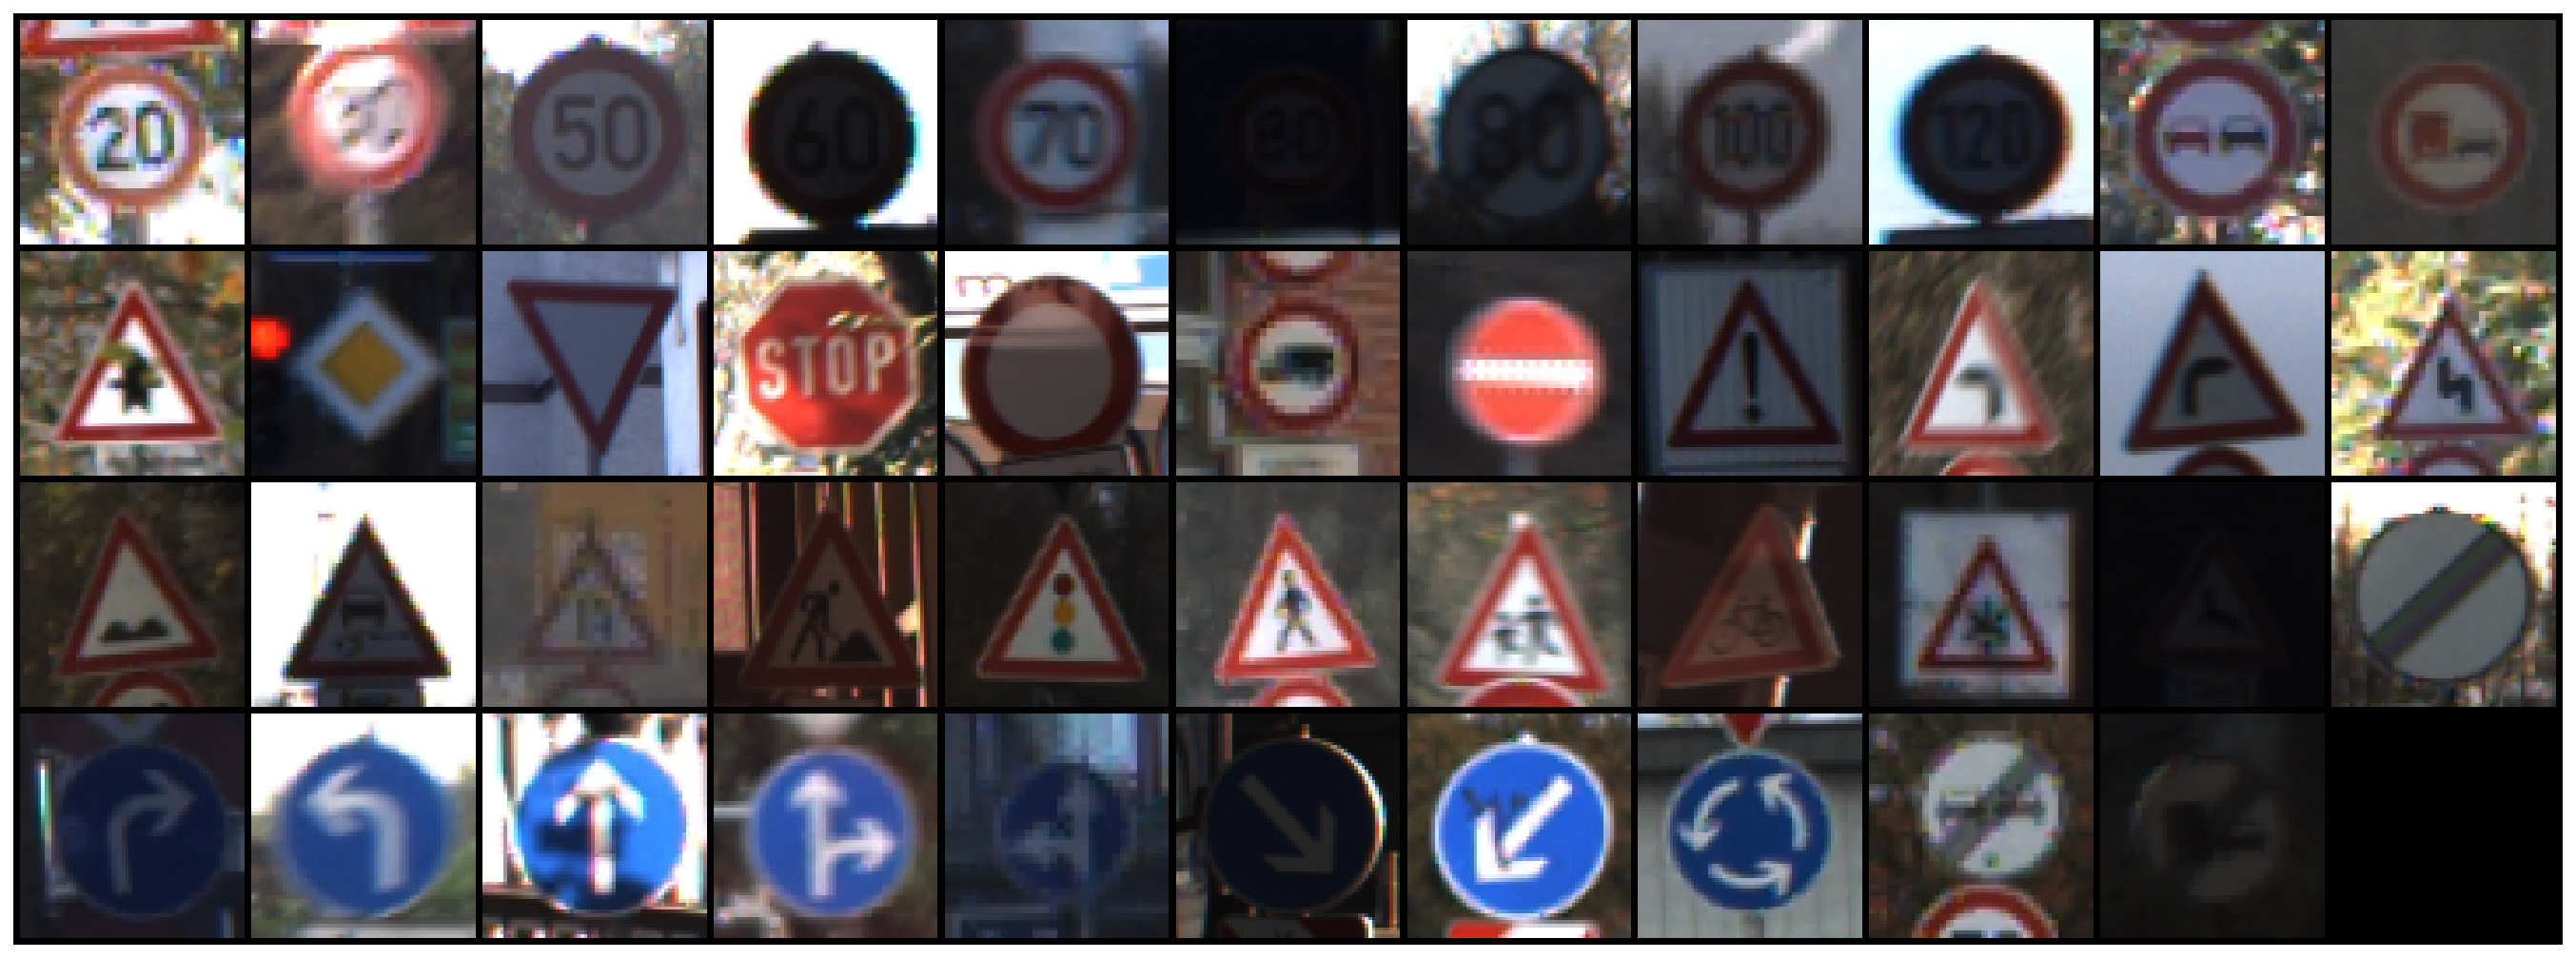

In [5]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
plot_signs(sample_images)

## Creating directories for each subset of the data - Train, Validation, Test
Update - this trial was not succesfull and I evenetually found another way to load the data

In [6]:
class_indices = np.arange(43)

In [7]:
!rm -rf data

classes = np.arange(43).astype(str)  # 43 classes and convert to string so it's useable in mkdir

DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in classes:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

### Now we have the desired folders!

## Splitting the data and checking its balance

In [8]:
images_count = np.zeros(43)

for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm')) # grab all paths
  class_name = classes[i]
  images_count[i] =  len(image_paths)  # save length so we can plot a graph later
  np.random.shuffle(image_paths) # shuffle all images because they are organized in a folder

  ## split data 80% train 10% val %10 test
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text major ticklabel objects>)

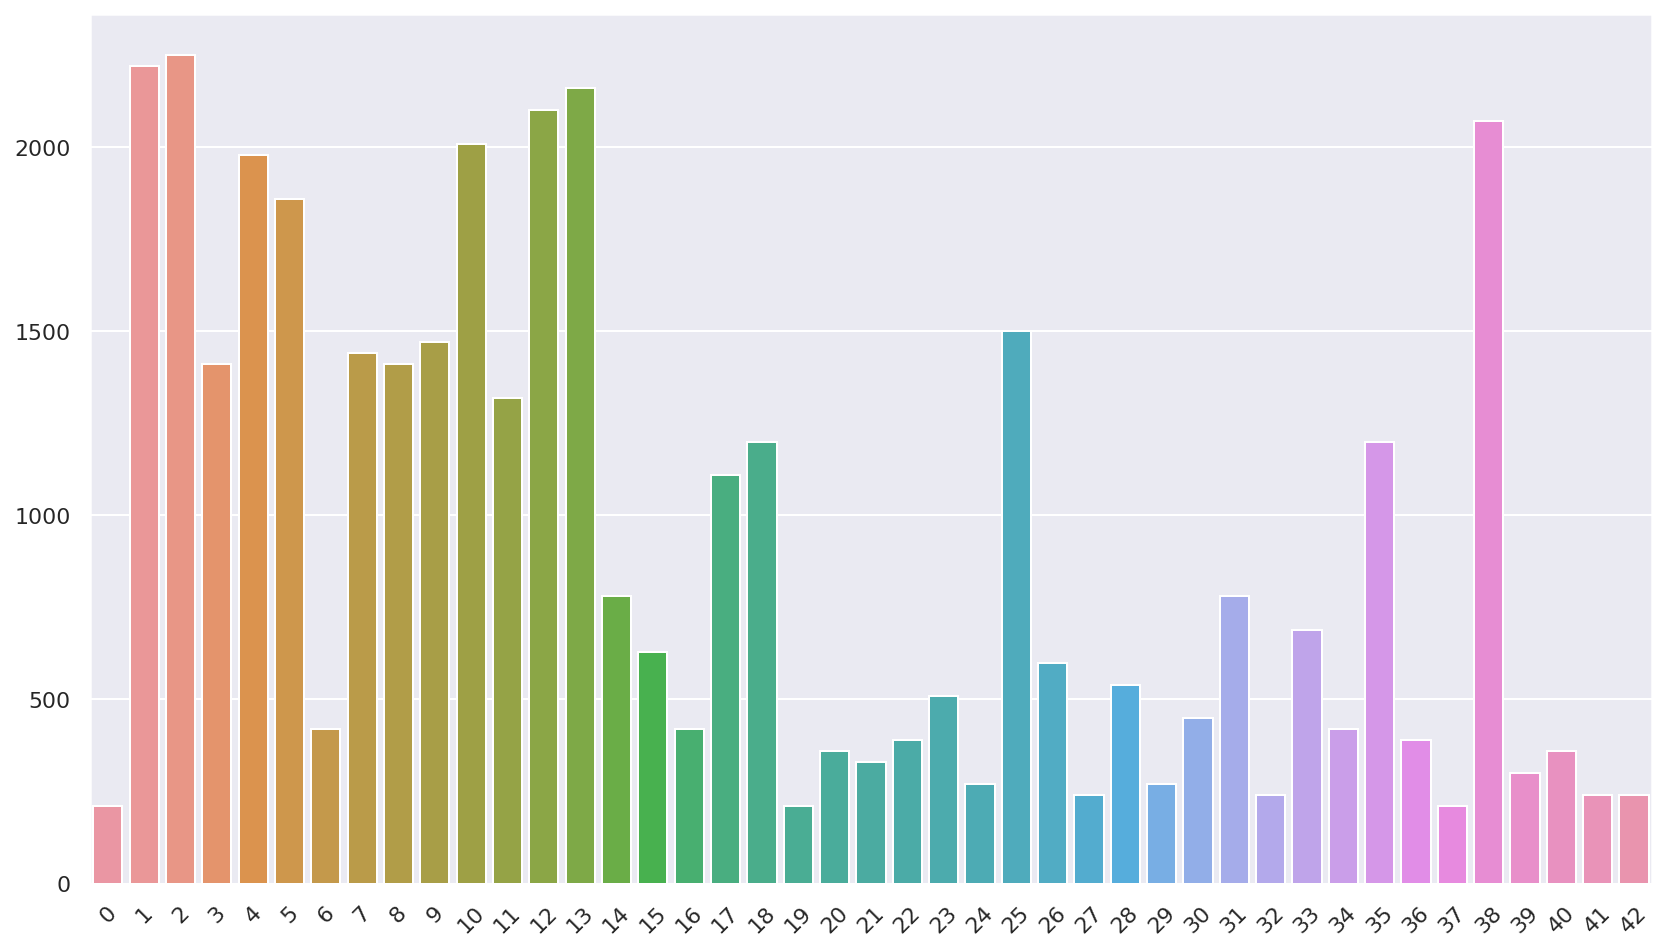

In [9]:
sns.set(rc={'figure.figsize':(14,8)})
sns.barplot(x=class_indices, y=images_count, orient='v')
plt.xticks(rotation=45)



### By looking at the graph we can see the data isn't well balanced, yet in most classes we have a decent amount of images, enough for training

# Image augmantation

## Creation of random transformations - chosen with common sense
* Resized Crop
* Rotation up to 15 degrees
* Horizontal flip
* Normalizing

In [10]:

transforms = T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # explained below
  ])


### After searching online, I found this dataset is actually given by PyTorch datasets class
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
##### Taken from PyTorch Docs

In [11]:
GTSRB_train = torchvision.datasets.GTSRB(root='/content/GTSRB',split='train',transform=transforms,download=True)  # work smart not hard

dataloader = DataLoader(
    dataset=GTSRB_train,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting /content/GTSRB/gtsrb/GTSRB-Training_fixed.zip to /content/GTSRB/gtsrb


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
len(GTSRB_train) # make sure the size is matching

26640

In [13]:
GTSRB_train[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

### Visualizing a few images
Function taken from PyTorch documentation
We need to reverse the normalization and reorder the color channels to get correct image data:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


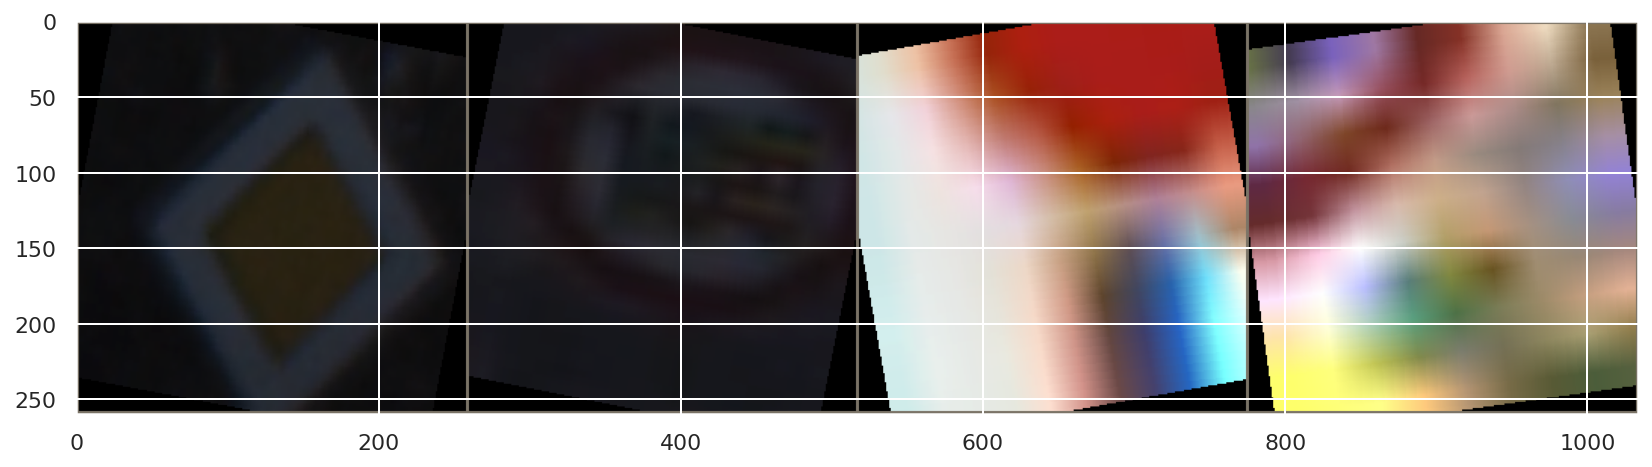

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# Model selection
After reading online I chose ResNet with 34 layer that is pretrained on ImageNet dataset.
https://towardsdatascience.com/resnet-for-traffic-sign-classification-with-pytorch-5883a97bbaa3

In [15]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

### Setting hyper parameters

In [16]:
base_model = create_model(43)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(base_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

The following code is from PyTorch docs as well, a little bit changed to be fit for my code.

In [17]:
def train_model(model, criterion, optimizer, scheduler, dataset_size, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = defaultdict(list)  # keeping records of the model during training, will be used later on to plot train and val loss/acc graphs


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # saving losses
            if phase == 'train':    
              history['train_acc'].append(epoch_acc)
              history['train_loss'].append(epoch_loss)
            else:
              history['val_acc'].append(epoch_acc)
              history['val_loss'].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [18]:
best_model, model_history = train_model(
    base_model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    dataset_size=len(GTSRB_train),
    num_epochs=10
     )

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 3.0663 Acc: 0.1513
val Loss: 2.6421 Acc: 0.2990

Epoch 1/9
----------
train Loss: 1.8993 Acc: 0.4042
val Loss: 1.4022 Acc: 0.5539

Epoch 2/9
----------
train Loss: 1.1726 Acc: 0.6229
val Loss: 0.9376 Acc: 0.6988

Epoch 3/9
----------
train Loss: 0.8123 Acc: 0.7419
val Loss: 0.6736 Acc: 0.7899

Epoch 4/9
----------
train Loss: 0.6589 Acc: 0.7932
val Loss: 0.5312 Acc: 0.8304

Epoch 5/9
----------
train Loss: 0.5481 Acc: 0.8254
val Loss: 0.4981 Acc: 0.8470

Epoch 6/9
----------
train Loss: 0.4935 Acc: 0.8427
val Loss: 0.4788 Acc: 0.8542

Epoch 7/9
----------
train Loss: 0.3567 Acc: 0.8862
val Loss: 0.3095 Acc: 0.9011

Epoch 8/9
----------
train Loss: 0.3221 Acc: 0.8986
val Loss: 0.3033 Acc: 0.9069

Epoch 9/9
----------
train Loss: 0.3077 Acc: 0.9020
val Loss: 0.2818 Acc: 0.9110

Training complete in 71m 32s
Best val Acc: 0.910961


<img src=https://i.ytimg.com/vi/LjTHGeUkHew/maxresdefault.jpg>

## After 71 minutes ...
# Let us see a little bit of the model prediction to make sure it is correct
#### the classes dictionary is below the predictions

In [19]:
classes = np.arange(43)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(3,num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


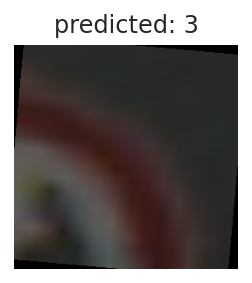

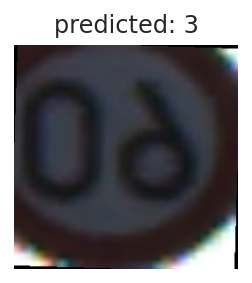

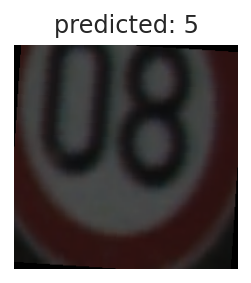

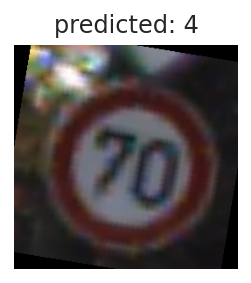

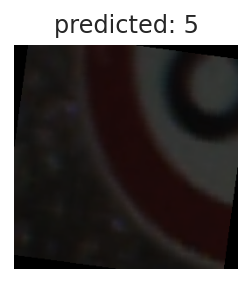

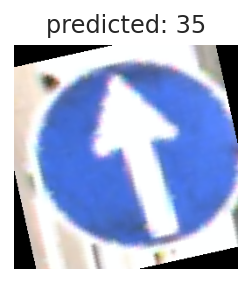

In [20]:
visualize_model(best_model) 

## Classes Dictionary

<img src="https://github.com/joshwadd/Deep-traffic-sign-classification/raw/master/ClassExamples2.png?raw=true">

## With the help of the training history we saved, lets see the training loss/accuracy stats!

In [21]:
model_history

defaultdict(list,
            {'train_acc': [tensor(0.1513, device='cuda:0', dtype=torch.float64),
              tensor(0.4042, device='cuda:0', dtype=torch.float64),
              tensor(0.6229, device='cuda:0', dtype=torch.float64),
              tensor(0.7419, device='cuda:0', dtype=torch.float64),
              tensor(0.7932, device='cuda:0', dtype=torch.float64),
              tensor(0.8254, device='cuda:0', dtype=torch.float64),
              tensor(0.8427, device='cuda:0', dtype=torch.float64),
              tensor(0.8862, device='cuda:0', dtype=torch.float64),
              tensor(0.8986, device='cuda:0', dtype=torch.float64),
              tensor(0.9020, device='cuda:0', dtype=torch.float64)],
             'train_loss': [3.0663462961131747,
              1.8993242088571056,
              1.1725669987784983,
              0.8123162402971732,
              0.658871443500484,
              0.5481240142554977,
              0.4935254603058843,
              0.3566827523272138,
   

In [22]:
model_history['train_acc'] = [x.cpu().item() for x in model_history['train_acc']]
model_history['val_acc'] = [x.cpu().item() for x in model_history['val_acc']]



In [23]:
model_history

defaultdict(list,
            {'train_acc': [0.1513138138138138,
              0.40420420420420416,
              0.6228603603603603,
              0.7419294294294294,
              0.7932057057057057,
              0.8253753753753753,
              0.8426801801801801,
              0.8862237237237237,
              0.8986486486486486,
              0.902027027027027],
             'train_loss': [3.0663462961131747,
              1.8993242088571056,
              1.1725669987784983,
              0.8123162402971732,
              0.658871443500484,
              0.5481240142554977,
              0.4935254603058843,
              0.3566827523272138,
              0.32211487727172233,
              0.30765197733148525],
             'val_acc': [0.299024024024024,
              0.5539039039039039,
              0.6987612612612613,
              0.7898648648648648,
              0.8304054054054054,
              0.8470345345345345,
              0.8542417417417417,
              0.90105105

In [24]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  # losses
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  # accuracy
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')



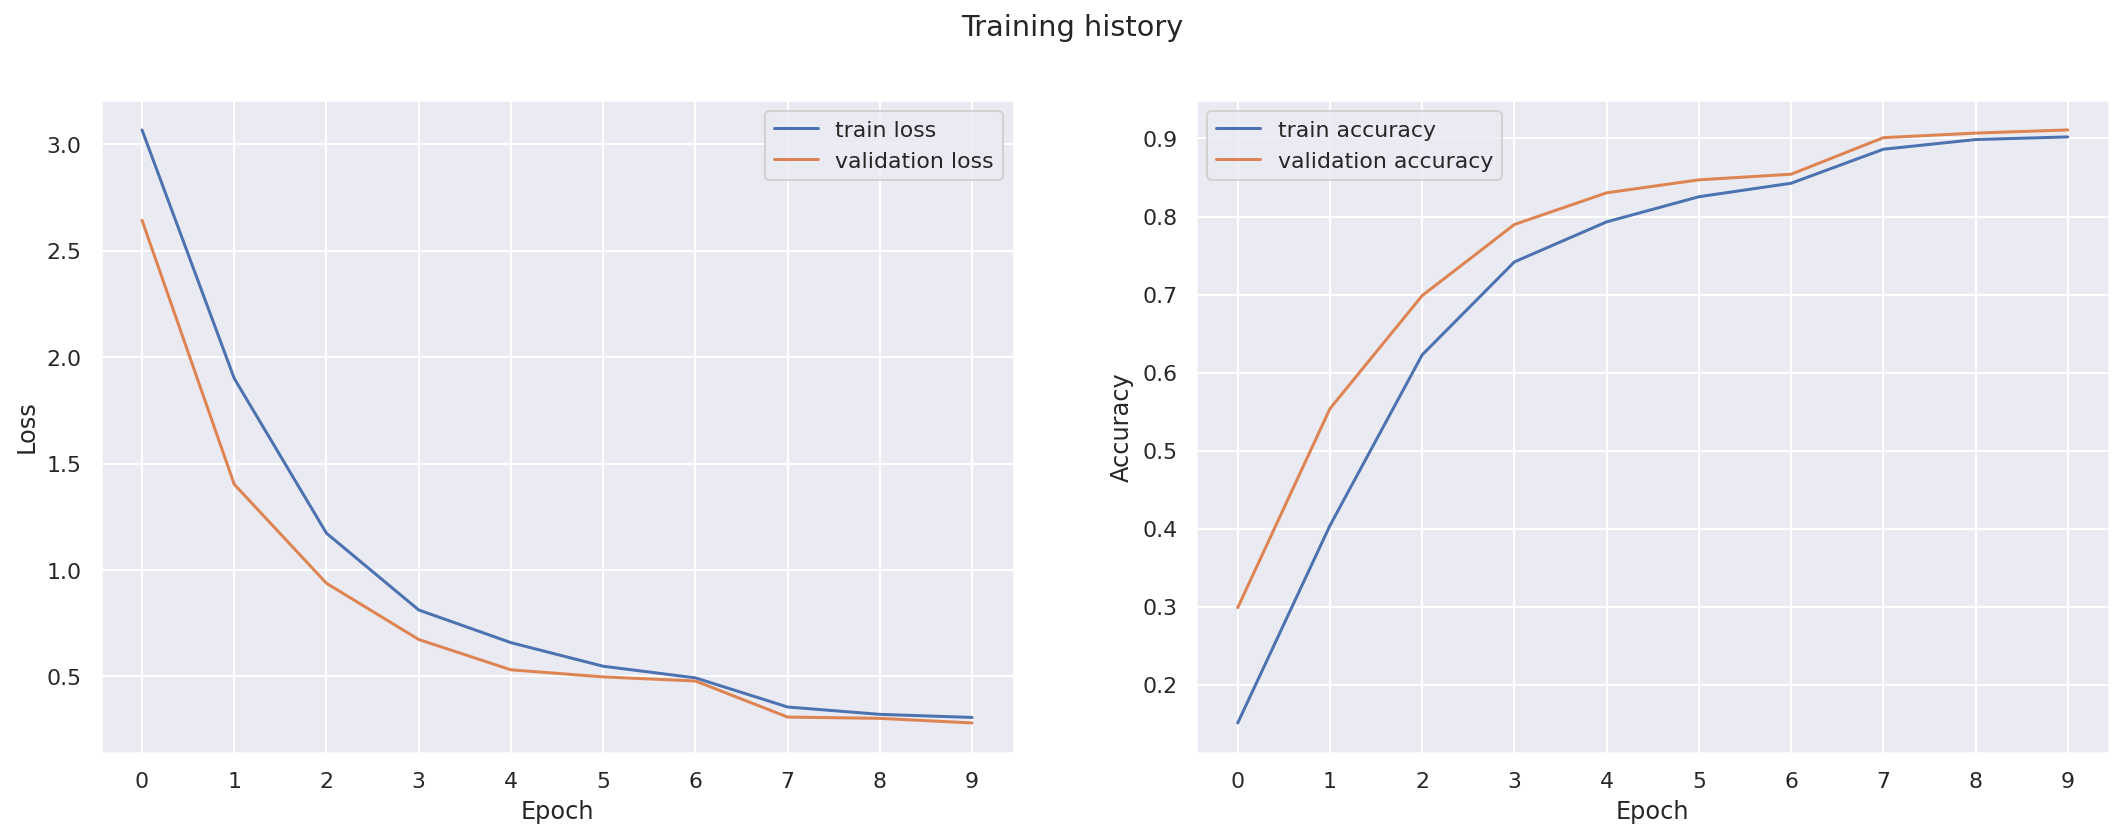

In [25]:
plot_training_history(model_history)

## Isn't it beautiful?

# More detailed metrics like Recall, Precision, and F1:

In a binary classification mission (only positive and negative):
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb'> 


In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values


In [27]:
y_pred, y_test = get_predictions(best_model, dataloader)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


              precision    recall  f1-score   support

           0       0.98      0.80      0.88       150
           1       0.93      0.89      0.91      1500
           2       0.91      0.91      0.91      1500
           3       0.95      0.86      0.90       960
           4       0.90      0.91      0.91      1320
           5       0.85      0.91      0.88      1260
           6       0.89      0.94      0.91       300
           7       0.94      0.92      0.93       960
           8       0.94      0.91      0.93       960
           9       0.93      0.94      0.94       990
          10       0.91      0.95      0.93      1350
          11       0.88      0.93      0.90       900
          12       0.97      0.98      0.98      1410
          13       0.97      0.97      0.97      1440
          14       0.98      0.96      0.97       540
          15       0.90      0.95      0.92       420
          16       0.91      0.93      0.92       300
          17       0.94    

# Test set predictions and submission

In [41]:
test_transforms = T.Compose([
  T.RandomResizedCrop(size=256),
  T.ToTensor(),
  T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])


In [54]:
GTSRB_Test = torchvision.datasets.GTSRB(root='/content/acc-german-traffic-sign-classification',split="test",transform=test_transforms,download=True)  # work smart not hard, again :)

dataloader_test = DataLoader(
    dataset=GTSRB_Test,
    batch_size=4,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
len(GTSRB_Test)

12630

In [57]:
output = open('mysubmission.csv', 'w+')
output.write('Filename,ClassID\n')

with torch.no_grad():

    for iteration, (X, y) in enumerate(dataloader_test): 
        X = X.cuda()
        scores = best_model(X)
        preds = torch.argmax(scores, dim=1)  
        for id,cla in zip(y,preds):
                output.write(f'{id},{cla.item()}\n') 
output.close()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [70]:
from google.colab import files
from IPython.display import Image

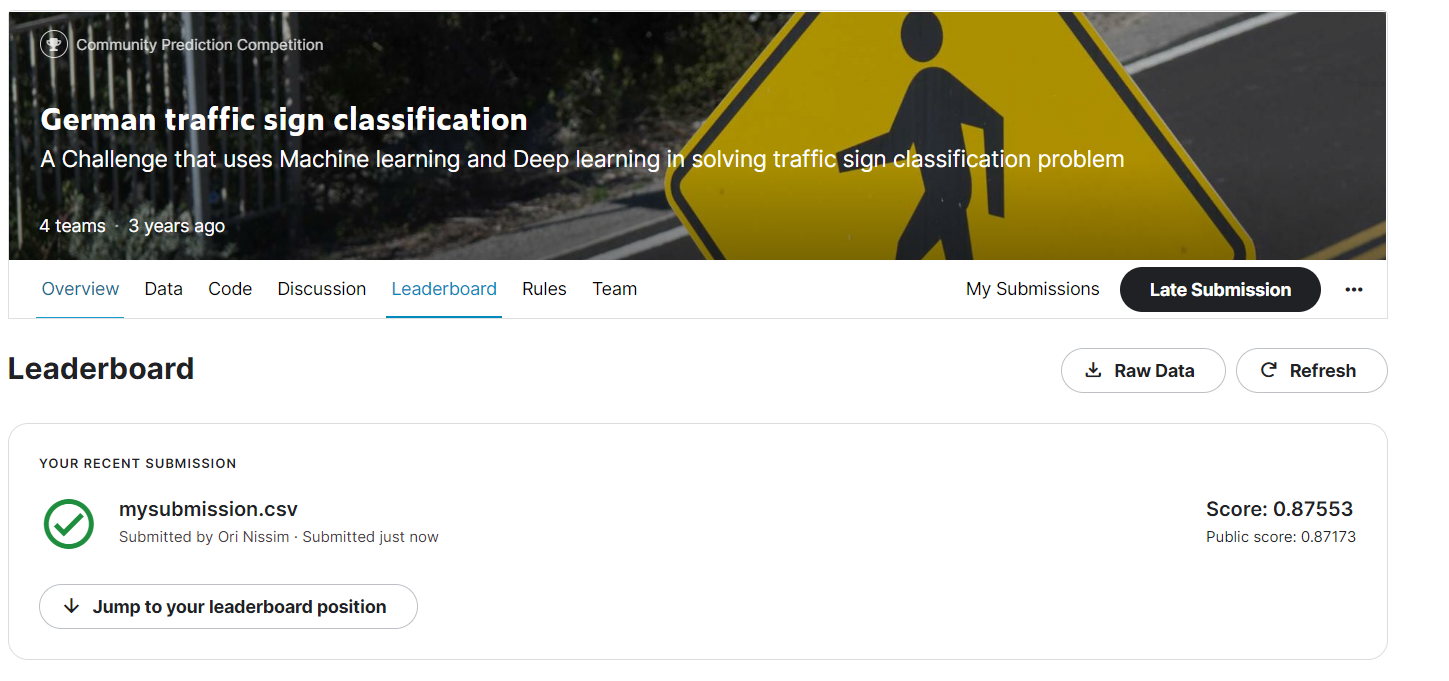

In [73]:
Image('/content/submission_screenshot.png')